# HPCA 2023 Supermarq Tutorial using `cirq-superstaq`

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supermarq/examples/Supermarq_HPCA_Tutorial_css.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/supermarq/examples/Supermarq_HPCA_Tutorial_css.ipynb)

You can run this notebook on [Colab](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/supermarq/examples/Supermarq_HPCA_Tutorial_css.ipynb) or [Binder](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FInfleqtion%252FSupermarQ%252Ftree%252Fmain%252Fexamples%26urlpath%3Dtree%252Fexamples%252FSupermarQ_HPCA_Tutorial.ipynb%26branch%3Dmain). The Colab requires sign in while Binder does not.

In [1]:
try:
    import cirq_superstaq as css
except ImportError:
    print("Installing cirq-superstaq...")
    %pip install --quiet 'cirq-superstaq[examples]'
    print("Installed cirq-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import cirq_superstaq as css

In [2]:
try:
    import supermarq
except ImportError:
    print("Installing supermarq...")
    %pip install --quiet supermarq
    print("Installed supermarq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import supermarq

## Basics:

### 1. Service creation

In [3]:
# Provide your api key to `css.Service()` using the `api_key=` argument if
# the SUPERSTAQ_API_KEY environment variable is not set.

# Submit cirq circuits via `cirq-superstaq`
service = css.Service()
print(service.get_balance())

868.14 credits


In [4]:
# See which targets are available
service.get_targets(available=True)

[Target(target='aqt_keysight_qpu', supports_submit=False, supports_submit_qubo=False, supports_compile=True, available=True, retired=False, accessible=True),
 Target(target='aqt_zurich_qpu', supports_submit=False, supports_submit_qubo=False, supports_compile=True, available=True, retired=False, accessible=True),
 Target(target='aws_dm1_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False, accessible=True),
 Target(target='aws_sv1_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False, accessible=True),
 Target(target='aws_tn1_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False, accessible=True),
 Target(target='cq_sqale_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False, accessible=True),
 Target(target='eeroq_wonderlake_qpu', supports_submi

### 2. Benchmark instantiation
NOTE: after executing a benchmark circuit, the score should always be evaluated using the same `Benchmark` object that was used to generate the circuit.

All of the benchmarks can be found in `supermarq/benchmarks/`.

Think about other circuits/benchmarks you would like to implement and run!

In [5]:
# Create your benchmark using cirq circuits
ghz = supermarq.ghz.GHZ(5)
print(ghz.cirq_circuit())

0: ───H───@───────────────M───
          │               │
1: ───────X───@───────────M───
              │           │
2: ───────────X───@───────M───
                  │       │
3: ───────────────X───@───M───
                      │   │
4: ───────────────────X───M───


### 3. Circuit evaluation
The generated circuits can be evaluated on a backend using any compatible service: AWS Braket, IBM Qiskit, `cirq-superstaq`, `qiskit-superstaq`, etc. Here we use `cirq-superstaq`

In [6]:
job_css = service.create_job(
    ghz.cirq_circuit(), repetitions=1000, target="ss_unconstrained_simulator", method="dry-run"
)

### 4. Compute the score
NOTE: after executing a benchmark circuit, the score should always be evaluated using the same `Benchmark` object that was used to generate the circuit.

In [7]:
job_css.status()

'Done'

In [8]:
counts = job_css.counts(0)
print(counts)
score_css = ghz.score(counts)
print(score_css)

{'11111': 520, '00000': 480}
0.9995998398718718


### 5. Visualize the results
The function in `supermarq.plotting.plot_results` produces a simple bar plot. Feel free to copy and paste that code here to generate more detailed figures.

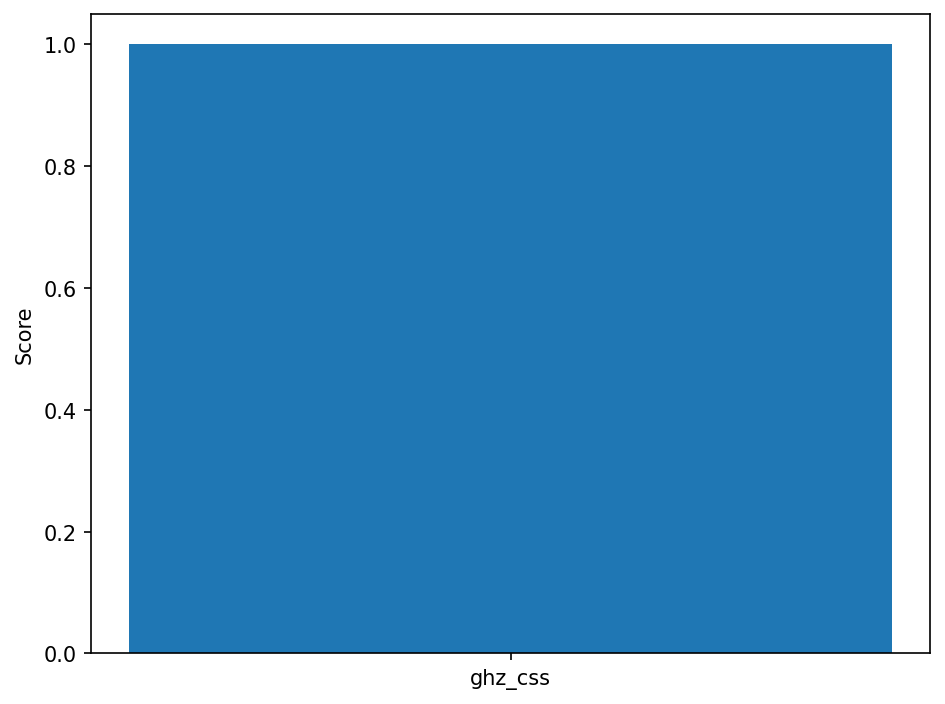

In [9]:
supermarq.plotting.plot_results([score_css], ["ghz_css"])

## Quantum Program Profiling
The current hardware-agnostic application features can be found in `supermarq/features.py`. Quantum program profiling is an exciting area of research that is just getting started -- what kinds of features would you find meaningful? Try implementing them!

### Compute features

In [10]:
ghz_circuit = supermarq.ghz.GHZ(10).cirq_circuit()
ghz_features = [
    supermarq.features.compute_communication(ghz_circuit),
    supermarq.features.compute_depth(ghz_circuit),
    supermarq.features.compute_entanglement(ghz_circuit),
    supermarq.features.compute_liveness(ghz_circuit),
    supermarq.features.compute_measurement(ghz_circuit),
    supermarq.features.compute_parallelism(ghz_circuit),
]
print(ghz_features)

[0.2, 1.0, 0.9, np.float64(0.2636363636363636), 0.0, 0]


### Visualize the feature vector

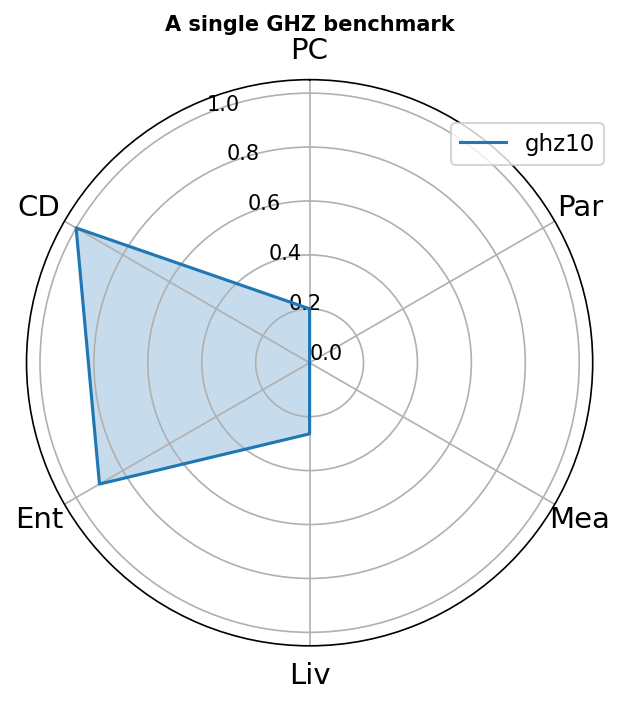

In [11]:
supermarq.plotting.plot_benchmark(
    title="A single GHZ benchmark",
    labels=["ghz10"],
    features=[ghz_features],
    spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
)

## Correlating performance <> features
To correlate the performance of a particular device with a certain application feature, it is helpful to evaluate several different benchmarks on that same device. This code example creates 4 different benchmarks, computes their feature vectors, evaluates them on a backend, and then measures the correlation between the performance seen and the application features.

### Characterize the benchmarks

In [12]:
benchmark_features = {}
benchmarks = [
    (supermarq.ghz.GHZ(5), "ghz5"),
    (supermarq.hamiltonian_simulation.HamiltonianSimulation(4), "hsim4"),
    (supermarq.mermin_bell.MerminBell(3), "mb3"),
    (supermarq.bit_code.BitCode(3, 3, [1, 0, 1]), "bitcode3"),
]
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.features.compute_communication(benchmark.cirq_circuit()),
        supermarq.features.compute_depth(benchmark.cirq_circuit()),
        supermarq.features.compute_entanglement(benchmark.cirq_circuit()),
        supermarq.features.compute_liveness(benchmark.cirq_circuit()),
        supermarq.features.compute_measurement(benchmark.cirq_circuit()),
        supermarq.features.compute_parallelism(benchmark.cirq_circuit()),
    ]
print(benchmark_features)

{'ghz5': [0.4, 1.0, 0.8, np.float64(0.4666666666666667), 0.0, 0], 'hsim4': [0.5, 1.0, 0.2857142857142857, np.float64(0.5961538461538461), 0.0, 0.20512820512820515], 'mb3': [1.0, 1.0, 0.4375, np.float64(0.6666666666666666), 0.0, 0.11538461538461542], 'bitcode3': [0.4, 0.5, 0.8571428571428571, np.float64(0.6142857142857143), 0.46153846153846156, 0.0]}


### Evaluate

In [13]:
jobs = []
for benchmark, label in benchmarks:
    job = service.create_job(
        benchmark.cirq_circuit(), repetitions=1000, target="ss_unconstrained_simulator"
    )
    jobs.append((label, job, benchmark))

### Wait until the benchmarks have successfully executed...

In [14]:
device_scores = {}
for label, job, benchmark in jobs:
    if job.status() == "Done":
        counts = job.counts(0)
        print(counts)
        score = benchmark.score(counts)
        print(score)
        device_scores[label] = score
    else:
        print(label, "not done!")

{'11111': 496, '00000': 504}
0.9999839997439919
{'0111': 109, '0011': 15, '1111': 508, '1011': 98, '1101': 99, '1110': 85, '0000': 1, '0110': 15, '1010': 15, '1100': 19, '1001': 20, '0101': 7, '0010': 4, '0100': 2, '1000': 1, '0001': 2}
0.9954466094067264
{'001': 1000}
1.0
{'11111110001': 1000}
1.0


### Measure the correlation between device performance and application features

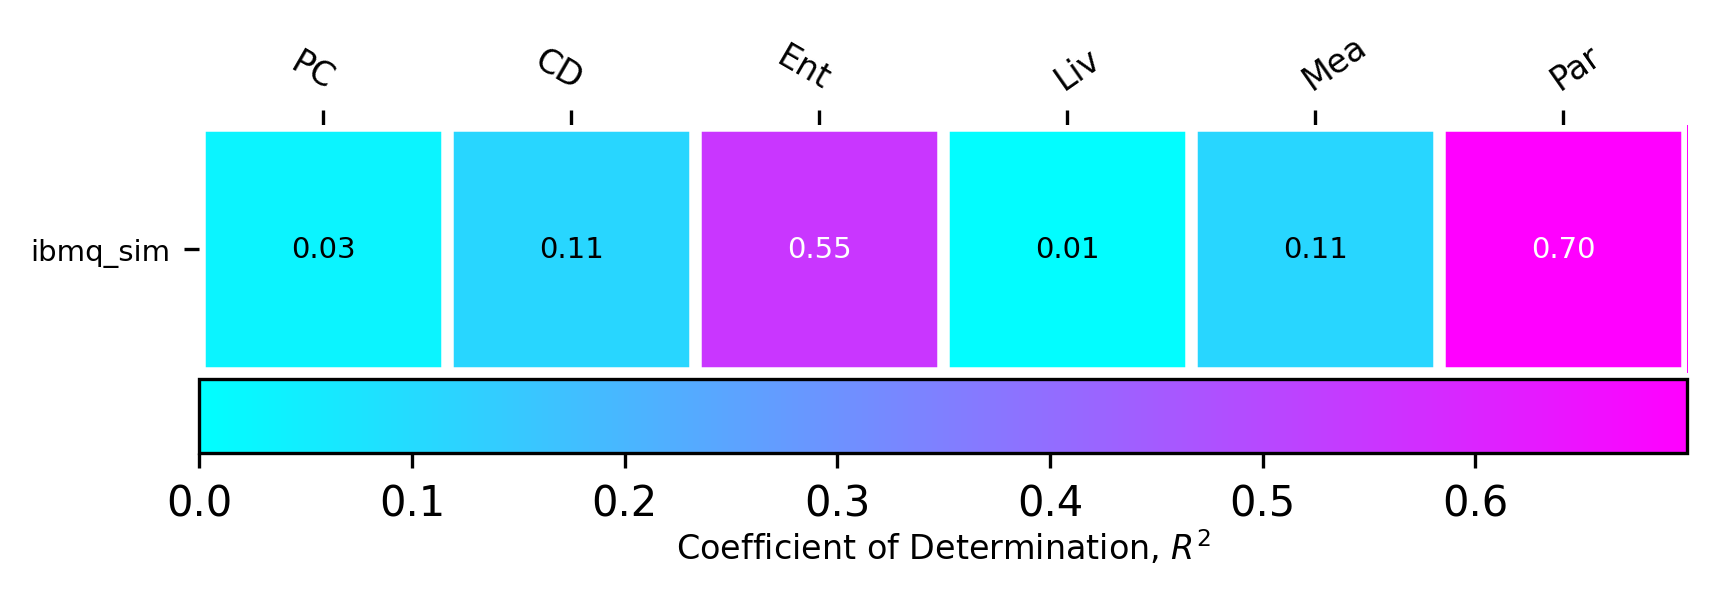

In [15]:
supermarq.plotting.plot_correlations(
    benchmark_features,
    device_scores,
    ["PC", "CD", "Ent", "Liv", "Mea", "Par"],
    device_name="ibmq_sim",
)